In [117]:
%%time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import numpy as np

# veri setini yükleme
train_data = pd.read_csv(r"C:\Users\asus\Downloads\cure_the_princess_train.csv")
valid_data = pd.read_csv(r"C:\Users\asus\Downloads\cure_the_princess_validation.csv")
test_data = pd.read_csv(r"C:\Users\asus\Downloads\cure_the_princess_test.csv")

# input boyutunu belirleme
input_size = len(train_data.columns) - 1 

CPU times: total: 15.6 ms
Wall time: 10 ms


In [118]:
%%time
class CustomDataset(Dataset):
    def __init__(self, data):
        self.X = data.iloc[:, :-1].values
        self.y = data.iloc[:, -1].values.reshape(-1, 1)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return torch.tensor(self.X[index], dtype=torch.float), torch.tensor(self.y[index], dtype=torch.float)
        
train_dataset = CustomDataset(train_data)
valid_dataset = CustomDataset(valid_data)
test_dataset = CustomDataset(test_data)

# DataLoader'larımızı tanımlayalım
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

CPU times: total: 0 ns
Wall time: 1.04 ms


In [119]:
%%time
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super().__init__()
        self.hidden_layer1 = nn.Linear(input_size, hidden_size1)
        self.hidden_layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.output_layer = nn.Linear(hidden_size2, output_size)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden_layer1(x))
        x = self.relu(self.hidden_layer2(x))
        x = self.sigmoid(self.output_layer(x))
        return x
output_size = len(np.unique(train_data.iloc[:, -1].values))

CPU times: total: 0 ns
Wall time: 996 µs


In [120]:
%%time
model = MLP(input_size=input_size, hidden_size1=100, hidden_size2=50, output_size=output_size)


CPU times: total: 0 ns
Wall time: 3 ms


In [121]:
%%time
def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device
DEVICE = set_device()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(190401017)



CPU times: total: 0 ns
Wall time: 2.97 ms


In [122]:
%%time
patience = 3
min_delta = 0.01


# loss fonksiyonu
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

# train fonksiyonu
def train(model, dataloader, criterion, optimizer):
    train_loss = 0
    train_acc = 0
    total = 0
    
    
    model.train()
    
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, targets.squeeze().long())
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        train_acc += (predicted == targets.squeeze().long()).sum().item()
        train_loss += loss.item() * inputs.size(0)
        
    return train_loss / total, train_acc / total
# evaluate fonksiyonu
def evaluate(model, dataloader, criterion):
    valid_loss = 0
    valid_acc = 0
    total = 0
    
    model.eval()
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets.squeeze().long())
            
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            valid_acc += (predicted == targets.squeeze().long()).sum().item()
            valid_loss += loss.item() * inputs.size(0)
        
    return valid_loss / total, valid_acc / total

# eğitim döngüsü
n_epochs = 50

best_valid_loss = np.inf

train_loss_list = []
valid_loss_list = []



for epoch in range(n_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion)
    
    # en iyi modeli kaydetme
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')
        
    print('Epoch: {}/{}  Train Loss: {:.4f}  Train Acc: {:.2f}%  Valid Loss: {:.4f}  Valid Acc: {:.2f}%'.format(epoch+1, n_epochs, train_loss, train_acc*100, valid_loss, valid_acc*100))
    
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

Epoch: 1/50  Train Loss: 0.6674  Train Acc: 59.66%  Valid Loss: 0.6004  Valid Acc: 72.93%
Epoch: 2/50  Train Loss: 0.5748  Train Acc: 77.64%  Valid Loss: 0.5128  Valid Acc: 84.71%
Epoch: 3/50  Train Loss: 0.5188  Train Acc: 83.15%  Valid Loss: 0.4777  Valid Acc: 88.22%
Epoch: 4/50  Train Loss: 0.4854  Train Acc: 85.22%  Valid Loss: 0.4440  Valid Acc: 89.17%
Epoch: 5/50  Train Loss: 0.4704  Train Acc: 85.54%  Valid Loss: 0.4265  Valid Acc: 91.40%
Epoch: 6/50  Train Loss: 0.4568  Train Acc: 87.06%  Valid Loss: 0.4259  Valid Acc: 91.08%
Epoch: 7/50  Train Loss: 0.4473  Train Acc: 88.50%  Valid Loss: 0.4228  Valid Acc: 90.45%
Epoch: 8/50  Train Loss: 0.4386  Train Acc: 89.38%  Valid Loss: 0.4160  Valid Acc: 91.72%
Epoch: 9/50  Train Loss: 0.4323  Train Acc: 89.78%  Valid Loss: 0.4052  Valid Acc: 91.72%
Epoch: 10/50  Train Loss: 0.4295  Train Acc: 89.38%  Valid Loss: 0.4427  Valid Acc: 86.62%
Epoch: 11/50  Train Loss: 0.4262  Train Acc: 90.02%  Valid Loss: 0.3979  Valid Acc: 92.36%
Epoch: 1

In [123]:
%%time
# en iyi modeli yükle
model.load_state_dict(torch.load('best_model.pt'))

# test fonksiyonu
def test(model, dataloader, criterion):
    test_loss = 0
    test_acc = 0
    total = 0
    
    model.eval()
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets.squeeze().long())
            
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            test_acc += (predicted == targets.squeeze().long()).sum().item()
            test_loss += loss.item() * inputs.size(0)
        
    return test_loss / total, test_acc / total
   
# test veri seti üzerinde model performansı
test_loss, test_acc = test(model, test_loader, criterion)

print('Test Loss: {:.4f}  Test Acc: {:.2f}%'.format(test_loss, test_acc*100))


Test Loss: 0.3727  Test Acc: 94.56%
CPU times: total: 188 ms
Wall time: 46 ms


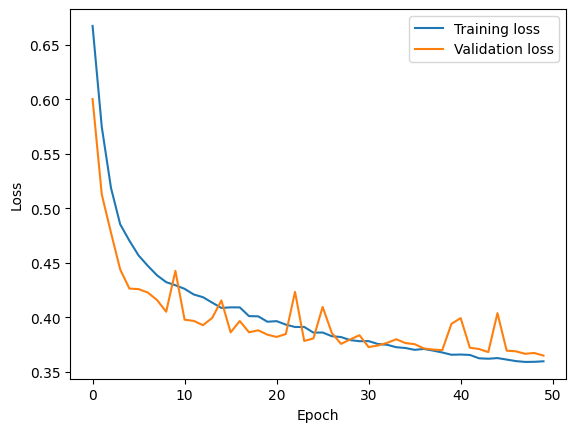

CPU times: total: 688 ms
Wall time: 220 ms


In [124]:
%%time
import seaborn as sns
import matplotlib.pyplot as plt

plt.plot(train_loss_list, label='Training loss')
plt.plot(valid_loss_list, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [115]:
%%time
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

y_true = []

y_pred = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = torch.argmax(outputs, dim=1)
        y_true += labels.cpu().tolist()
        y_pred += predicted.cpu().tolist()

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print('Accuracy:', accuracy)
print('F1 score:', f1)
print('Precision:', precision)
print('Recall:', recall)

Accuracy: 0.9365284974093264
F1 score: 0.9364388054635608
Precision: 0.9395717229033674
Recall: 0.9367482817869416
CPU times: total: 250 ms
Wall time: 63 ms
